In [1]:
import os
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import pickle
import openpyxl

from matplotlib.colors import ListedColormap,Normalize,BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

C:\Users\mye500\AppData\Local\Temp\ipykernel_11084\209953356.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
data_path = os.path.join('C:\\','data')
output_path = os.path.join('C:\\','projects','pg_risk_analysis_output','output')
risk_path = os.path.join(output_path,'risk')
figure_path = os.path.join('C:\\','projects','pg_risk_analysis','figures')

# Load datasets with additional information about countries to create the maps

In [3]:
ne_countries = gpd.read_file(os.path.join(data_path,'natural_earth','ne_10m_admin_0_countries.shp'))
ne_sindex = ne_countries.sindex
#incomegroups = pd.read_csv(os.path.join(data_path,'input_data','incomegroups_2018.csv'),index_col=[0])

# Read and restructure risk results

In [4]:
def read_risk(hazard_type,infra_type):
    """
    Read the risk results of historical (FL) and present (TC) climate model
    """
    outputs = {}
    for risk_output in os.listdir(risk_path):
        climate_model = os.path.splitext(risk_output)[0].split('_')[3]
        if (hazard_type in risk_output) & (infra_type in risk_output) & (climate_model in risk_output):
            check_sheets = pd.ExcelFile(os.path.join(risk_path,risk_output),engine='openpyxl').sheet_names
            for sheet in check_sheets:
                out = pd.read_excel(os.path.join(risk_path,risk_output),sheet_name= sheet, index_col=[0],engine='openpyxl')
                outputs[risk_output[:3],climate_model,sheet] = out
    df = pd.concat(outputs).unstack(level=2).dropna(axis=1, how='all')
    #df.to_csv(os.path.join(output_path,'{}_risk.csv'.format(hazard_type)))
    
    return df

In [5]:
def restructure_risk(hazard_type,climate_model):
    df = read_risk(hazard_type,'osm')
    
    # country_codes does not include SGP
    country_codes = ['BRN','CHN','IDN','JPN','KHM','KOR','LAO','MMR','MNG','MYS','PHL','PRK','SGP','THA','TWN','VNM']
       
    reframe_risk = {}
    model_risk = {}
        
    for country_code in country_codes:
        reframe_risk[country_code] = df.unstack(level=-1).T.unstack(level=-1)[country_code]

        model_risk[country_code] = reframe_risk[country_code][climate_model].reset_index()
        model_risk[country_code] = model_risk[country_code].rename(columns={'level_0':'curve_code', 'level_1':'asset_type'})
        model_risk[country_code]['country_code'] = country_code
        model_risk[country_code]['climate_model'] = climate_model
        model_risk[country_code]['infra_type'] = 'osm'

        df_risk_result = pd.concat(model_risk.values(), keys=model_risk.keys())
        risk_result = pd.concat([df_risk_result])
            
    return risk_result[['country_code','asset_type','mean_risk','lower_risk','upper_risk']]

In [6]:
restructure_risk('fl','historical')#[['country_code','asset_type','mean_risk','lower_risk','upper_risk']]

0      country_code  asset_type     mean_risk   lower_risk    upper_risk
BRN 0           BRN   line_risk           NaN          NaN           NaN
    1           BRN   line_risk           NaN          NaN           NaN
    2           BRN   line_risk           NaN          NaN           NaN
    3           BRN   line_risk           NaN          NaN           NaN
    4           BRN   line_risk           NaN          NaN           NaN
...             ...         ...           ...          ...           ...
VNM 19          VNM  tower_risk  10814.996324  8111.247243  13518.745404
    20          VNM   pole_risk           NaN          NaN           NaN
    21          VNM   pole_risk           NaN          NaN           NaN
    22          VNM   pole_risk           NaN          NaN           NaN
    23          VNM   pole_risk           NaN          NaN           NaN

[384 rows x 5 columns]

## Historical risk of tropical cyclone

In [7]:
# calculate FL osm hist mean risk for each infrastructure type
df = restructure_risk('tc','present')

tc_hist_risk = pd.DataFrame(columns=['country_code','asset_type','mean_risk'])

# Group df according to the country code and asset type, and calculate the mean value of all mean risks for each infrastructure type
grouped_df = df.groupby(['country_code', 'asset_type'])['mean_risk'].mean().reset_index()

tc_hist_risk['country_code'] = grouped_df['country_code']
tc_hist_risk['asset_type'] = grouped_df['asset_type']
tc_hist_risk['mean_risk'] = grouped_df['mean_risk']
tc_hist_risk['climate_model'] = 'present'

tc_hist_risk

,country_code,asset_type,mean_risk,climate_model
0,BRN,line_risk,NaN,present
1,BRN,pole_risk,NaN,present
2,BRN,substation_risk,8.076186e+04,present
3,BRN,tower_risk,NaN,present
4,CHN,line_risk,7.731197e+09,present
...,...,...,...,...
59,TWN,tower_risk,8.736406e+07,present
60,VNM,line_risk,1.276783e+08,present
61,VNM,pole_risk,7.106495e+04,present
62,VNM,substation_risk,3.017798e+04,present


In [8]:
# calculate FL osm hist sum risk for each country
sum_tc_hist_risk = pd.DataFrame(columns=['country_code','climate_model','sum_risk'])

grouped_tc_hist_risk = tc_hist_risk.groupby('country_code')['mean_risk'].sum().reset_index()

sum_tc_hist_risk['country_code'] = grouped_tc_hist_risk['country_code']
sum_tc_hist_risk['sum_risk'] = grouped_tc_hist_risk['mean_risk']
sum_tc_hist_risk['climate_model'] = tc_hist_risk.groupby('country_code')['climate_model'].first().values

sum_tc_hist_risk

,country_code,climate_model,sum_risk
0,BRN,present,8.076186e+04
1,CHN,present,8.174863e+09
2,IDN,present,1.495002e+08
3,JPN,present,1.111510e+10
4,KHM,present,6.173831e+06
5,KOR,present,1.874807e+09
6,LAO,present,3.673431e+07
7,MMR,present,1.583152e+07
8,MNG,present,9.728763e+06
9,MYS,present,4.521421e+07


## Future risk of tropical cyclone (4 climate models)

In [9]:
climate_models = ['CMCC-CM2-VHR4','CNRM-CM6-1-HR','EC-Earth3P-HR','HadGEM3-GC31-HM']

cmcc_risk = restructure_risk('tc','CMCC-CM2-VHR4')
cnrm_risk = restructure_risk('tc','CNRM-CM6-1-HR')
ec_risk = restructure_risk('tc','EC-Earth3P-HR')
had_risk = restructure_risk('tc','HadGEM3-GC31-HM')

In [10]:
# calculate TC osm mean risk of each climate model for each infrastructure type
cmcc_risk_new = pd.DataFrame(columns=['country_code', 'asset_type', 'mean_risk'])
cnrm_risk_new = pd.DataFrame(columns=['country_code', 'asset_type', 'mean_risk'])
ec_risk_new = pd.DataFrame(columns=['country_code', 'asset_type', 'mean_risk'])
had_risk_new = pd.DataFrame(columns=['country_code', 'asset_type', 'mean_risk'])

# Group df according to the country code and asset type, and calculate the mean value of all mean risks for each infrastructure type
grouped_cmcc_risk = cmcc_risk.groupby(['country_code', 'asset_type'])['mean_risk'].mean().reset_index()
grouped_cnrm_risk = cnrm_risk.groupby(['country_code', 'asset_type'])['mean_risk'].mean().reset_index()
grouped_ec_risk = ec_risk.groupby(['country_code', 'asset_type'])['mean_risk'].mean().reset_index()
grouped_had_risk = had_risk.groupby(['country_code', 'asset_type'])['mean_risk'].mean().reset_index()

cmcc_risk_new['country_code'] = grouped_cmcc_risk['country_code']
cmcc_risk_new['asset_type'] = grouped_cmcc_risk['asset_type']
cmcc_risk_new['mean_risk'] = grouped_cmcc_risk['mean_risk']
cmcc_risk_new['climate_model'] = 'CMCC-CM2-VHR4'

cnrm_risk_new['country_code'] = grouped_cnrm_risk['country_code']
cnrm_risk_new['asset_type'] = grouped_cnrm_risk['asset_type']
cnrm_risk_new['mean_risk'] = grouped_cnrm_risk['mean_risk']
cnrm_risk_new['climate_model'] = 'CNRM-CM6-1-HR'

ec_risk_new['country_code'] = grouped_ec_risk['country_code']
ec_risk_new['asset_type'] = grouped_ec_risk['asset_type']
ec_risk_new['mean_risk'] = grouped_ec_risk['mean_risk']
ec_risk_new['climate_model'] = 'EC-Earth3P-HR'

had_risk_new['country_code'] = grouped_had_risk['country_code']
had_risk_new['asset_type'] = grouped_had_risk['asset_type']
had_risk_new['mean_risk'] = grouped_had_risk['mean_risk']
had_risk_new['climate_model'] = 'HadGEM3-GC31-HM'

In [11]:
# calculate TC CMCC-CM2-VHR4 risk
sum_tc_cmcc_risk = pd.DataFrame(columns=['country_code','climate_model','sum_risk'])
grouped_tc_cmcc_risk = cmcc_risk_new.groupby('country_code')['mean_risk'].sum().reset_index()
sum_tc_cmcc_risk['country_code'] = grouped_tc_cmcc_risk['country_code']
sum_tc_cmcc_risk['sum_risk'] = grouped_tc_cmcc_risk['mean_risk']
sum_tc_cmcc_risk['climate_model'] = cmcc_risk_new.groupby('country_code')['climate_model'].first().values

# calculate TC CNRM-CM6-1-HR risk
sum_tc_cnrm_risk = pd.DataFrame(columns=['country_code','climate_model','sum_risk'])
grouped_tc_cnrm_risk = cnrm_risk_new.groupby('country_code')['mean_risk'].sum().reset_index()
sum_tc_cnrm_risk['country_code'] = grouped_tc_cnrm_risk['country_code']
sum_tc_cnrm_risk['sum_risk'] = grouped_tc_cnrm_risk['mean_risk']
sum_tc_cnrm_risk['climate_model'] = cnrm_risk_new.groupby('country_code')['climate_model'].first().values

# calculate TC EC-Earth3P-HR risk
sum_tc_ec_risk = pd.DataFrame(columns=['country_code','climate_model','sum_risk'])
grouped_tc_ec_risk = ec_risk_new.groupby('country_code')['mean_risk'].sum().reset_index()
sum_tc_ec_risk['country_code'] = grouped_tc_ec_risk['country_code']
sum_tc_ec_risk['sum_risk'] = grouped_tc_ec_risk['mean_risk']
sum_tc_ec_risk['climate_model'] = ec_risk_new.groupby('country_code')['climate_model'].first().values

# calculate TC HadGEM3-GC31-HM risk
sum_tc_had_risk = pd.DataFrame(columns=['country_code','climate_model','sum_risk'])
grouped_tc_had_risk = had_risk_new.groupby('country_code')['mean_risk'].sum().reset_index()
sum_tc_had_risk['country_code'] = grouped_tc_had_risk['country_code']
sum_tc_had_risk['sum_risk'] = grouped_tc_had_risk['mean_risk']
sum_tc_had_risk['climate_model'] = had_risk_new.groupby('country_code')['climate_model'].first().values

In [12]:
sum_tc_had_risk

,country_code,climate_model,sum_risk
0,BRN,HadGEM3-GC31-HM,7.442065e+04
1,CHN,HadGEM3-GC31-HM,1.223857e+10
2,IDN,HadGEM3-GC31-HM,1.784683e+08
3,JPN,HadGEM3-GC31-HM,1.521346e+10
4,KHM,HadGEM3-GC31-HM,7.183472e+06
5,KOR,HadGEM3-GC31-HM,2.575756e+09
6,LAO,HadGEM3-GC31-HM,4.147785e+07
7,MMR,HadGEM3-GC31-HM,2.476200e+07
8,MNG,HadGEM3-GC31-HM,1.852645e+07
9,MYS,HadGEM3-GC31-HM,1.034467e+08


In [13]:
# calculate TC osm future mean risk for each infrastructure type (mean risk of four climate models)
df = pd.concat([cmcc_risk_new,cnrm_risk_new,ec_risk_new,had_risk_new], axis=0)
grouped_df = df.groupby(['country_code', 'asset_type'])['mean_risk'].mean().reset_index()

tc_future_risk = pd.DataFrame(columns=['country_code', 'asset_type', 'mean_risk'])

tc_future_risk['country_code'] = grouped_df['country_code']
tc_future_risk['asset_type'] = grouped_df['asset_type']
tc_future_risk['mean_risk'] = grouped_df['mean_risk']
tc_future_risk['climate_model'] = 'future'
tc_future_risk

,country_code,asset_type,mean_risk,climate_model
0,BRN,line_risk,NaN,future
1,BRN,pole_risk,NaN,future
2,BRN,substation_risk,7.575365e+04,future
3,BRN,tower_risk,NaN,future
4,CHN,line_risk,1.142104e+10,future
...,...,...,...,...
59,TWN,tower_risk,1.075432e+08,future
60,VNM,line_risk,1.800643e+08,future
61,VNM,pole_risk,9.220068e+04,future
62,VNM,substation_risk,7.417105e+04,future


In [14]:
# calculate TC future sum risk for each country
sum_tc_future_risk = pd.DataFrame(columns=['country_code', 'climate_model', 'sum_risk'])

grouped_tc_future_risk = tc_future_risk.groupby('country_code')['mean_risk'].sum().reset_index()

sum_tc_future_risk['country_code'] = grouped_tc_future_risk['country_code']
sum_tc_future_risk['sum_risk'] = grouped_tc_future_risk['mean_risk']
sum_tc_future_risk['climate_model'] = tc_future_risk.groupby('country_code')['climate_model'].first().values

sum_tc_future_risk

,country_code,climate_model,sum_risk
0,BRN,future,7.575365e+04
1,CHN,future,1.203561e+10
2,IDN,future,1.786731e+08
3,JPN,future,1.410710e+10
4,KHM,future,7.113838e+06
5,KOR,future,2.400641e+09
6,LAO,future,4.180646e+07
7,MMR,future,2.484196e+07
8,MNG,future,2.919392e+07
9,MYS,future,1.033776e+08


In [81]:
# Assemble tc risks
tc_risk = pd.concat([sum_tc_hist_risk,sum_tc_cmcc_risk,sum_tc_cnrm_risk,sum_tc_ec_risk,sum_tc_had_risk,sum_tc_future_risk],axis=1)

tc_risk.columns.values[2]='Present'
tc_risk.columns.values[5]='CMCC-CM2-VHR4'
tc_risk.columns.values[8]='CNRM-CM6-1-HR'
tc_risk.columns.values[11]='EC-Earth3P-HR'
tc_risk.columns.values[14]='HadGEM3-GC31-HM'
tc_risk.columns.values[17]='Mean risk of climate models'

tc_risk = tc_risk.drop(tc_risk.columns[[3,4,6,7,9,10,12,13,15,16]], axis=1)
# tc_risk = tc_risk.drop(tc_risk.columns[[3,6,9,12,15]], axis=1)

tc_risk.insert(0,'country_code',['BRN','CHN','IDN','JPN','KHM','KOR','LAO','MMR','MNG','MYS','PHL','PRK','SGP','THA','TWN','VNM'])
#tc_risk = tc_risk.set_index('country_code')

tc_risk['CMCC-CM2-VHR4 change ratio (%)'] = (tc_risk['CMCC-CM2-VHR4'] - tc_risk['Present']) / tc_risk['Present'] * 100
tc_risk['CNRM-CM6-1-HR change ratio (%)'] = (tc_risk['CNRM-CM6-1-HR'] - tc_risk['Present']) / tc_risk['Present'] * 100
tc_risk['EC-Earth3P-HR change ratio (%)'] = (tc_risk['EC-Earth3P-HR'] - tc_risk['Present']) / tc_risk['Present'] * 100
tc_risk['HadGEM3-GC31-HM change ratio (%)'] = (tc_risk['HadGEM3-GC31-HM'] - tc_risk['Present']) / tc_risk['Present'] * 100
tc_risk['Mean risk change ratio (%)'] = (tc_risk['Mean risk of climate models'] - tc_risk['Present']) / tc_risk['Present'] * 100
tc_risk

,country_code,Present,CMCC-CM2-VHR4,CNRM-CM6-1-HR,EC-Earth3P-HR,HadGEM3-GC31-HM,Mean risk of climate models,CMCC-CM2-VHR4 change ratio (%),CNRM-CM6-1-HR change ratio (%),EC-Earth3P-HR change ratio (%),HadGEM3-GC31-HM change ratio (%),Mean risk change ratio (%)
0,BRN,8.076186e+04,7.433078e+04,8.039126e+04,7.387190e+04,7.442065e+04,7.575365e+04,-7.963020,-0.458885,-8.531213,-7.851737,-6.201214
1,CHN,8.174863e+09,1.121884e+10,1.326635e+10,1.141870e+10,1.223857e+10,1.203561e+10,37.235805,62.282255,39.680592,49.709745,47.227099
2,IDN,1.495002e+08,1.800334e+08,1.780917e+08,1.780989e+08,1.784683e+08,1.786731e+08,20.423458,19.124712,19.129490,19.376593,19.513563
3,JPN,1.111510e+10,1.313643e+10,1.392765e+10,1.415085e+10,1.521346e+10,1.410710e+10,18.185454,25.303862,27.311912,36.871996,26.918306
4,KHM,6.173831e+06,7.100059e+06,7.095910e+06,7.075912e+06,7.183472e+06,7.113838e+06,15.002472,14.935281,14.611363,16.353559,15.225669
5,KOR,1.874807e+09,2.228785e+09,2.399592e+09,2.398432e+09,2.575756e+09,2.400641e+09,18.880740,27.991429,27.929529,37.387771,28.047367
6,LAO,3.673431e+07,4.235197e+07,4.219049e+07,4.120552e+07,4.147785e+07,4.180646e+07,15.292667,14.853069,12.171738,12.913106,13.807645
7,MMR,1.583152e+07,2.538683e+07,2.409693e+07,2.512209e+07,2.476200e+07,2.484196e+07,60.356255,52.208594,58.683998,56.409519,56.914592
8,MNG,9.728763e+06,2.472887e+07,3.978803e+07,3.373233e+07,1.852645e+07,2.919392e+07,154.183035,308.973154,246.727828,90.429655,200.078418
9,MYS,4.521421e+07,1.035082e+08,1.027492e+08,1.038065e+08,1.034467e+08,1.033776e+08,128.928477,127.249691,129.588310,128.792402,128.639720


## Historical risk of tropical cyclone

In [16]:
# calculate FL osm hist mean risk for each infrastructure type
df = restructure_risk('fl','historical')

fl_hist_risk = pd.DataFrame(columns=['country_code','asset_type','mean_risk','lower_risk','upper_risk'])

# Group df according to the country code and asset type, and calculate the mean value of all mean risks for each infrastructure type
grouped_df = df.groupby(['country_code', 'asset_type'])['mean_risk','lower_risk','upper_risk'].mean().reset_index()

fl_hist_risk['country_code'] = grouped_df['country_code']
fl_hist_risk['asset_type'] = grouped_df['asset_type']
fl_hist_risk['mean_risk'] = grouped_df['mean_risk']
fl_hist_risk['lower_risk'] = grouped_df['lower_risk']
fl_hist_risk['upper_risk'] = grouped_df['upper_risk']

fl_hist_risk['climate_model'] = 'historical'

fl_hist_risk

C:\Users\mye500\AppData\Local\Temp\ipykernel_11084\718777988.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df = df.groupby(['country_code', 'asset_type'])['mean_risk','lower_risk','upper_risk'].mean().reset_index()


,country_code,asset_type,mean_risk,lower_risk,upper_risk,climate_model
0,BRN,line_risk,NaN,NaN,NaN,historical
1,BRN,plant_risk,NaN,NaN,NaN,historical
2,BRN,pole_risk,NaN,NaN,NaN,historical
3,BRN,substation_risk,NaN,NaN,NaN,historical
4,BRN,tower_risk,NaN,NaN,NaN,historical
...,...,...,...,...,...,...
75,VNM,line_risk,5.117191e+04,3.837893e+04,6.396489e+04,historical
76,VNM,plant_risk,1.662761e+07,1.247071e+07,2.078452e+07,historical
77,VNM,pole_risk,NaN,NaN,NaN,historical
78,VNM,substation_risk,1.639356e+03,1.229517e+03,2.049195e+03,historical


In [17]:
# calculate FL osm hist sum risk for each country
sum_fl_hist_risk = pd.DataFrame(columns=['country_code','climate_model','sum_risk'])

grouped_fl_hist_risk = fl_hist_risk.groupby('country_code')['mean_risk'].sum().reset_index()

sum_fl_hist_risk['country_code'] = grouped_fl_hist_risk['country_code']
sum_fl_hist_risk['sum_risk'] = grouped_fl_hist_risk['mean_risk']
sum_fl_hist_risk['climate_model'] = fl_hist_risk.groupby('country_code')['climate_model'].first().values

sum_fl_hist_risk

,country_code,climate_model,sum_risk
0,BRN,historical,0.000000e+00
1,CHN,historical,9.009527e+08
2,IDN,historical,3.157823e+07
3,JPN,historical,1.589489e+09
4,KHM,historical,0.000000e+00
5,KOR,historical,3.496957e+08
6,LAO,historical,0.000000e+00
7,MMR,historical,5.442522e+04
8,MNG,historical,0.000000e+00
9,MYS,historical,9.325174e+06


## Future risk of coastal flood (rcp8.5)

In [18]:
# calculate FL osm rcp mean risk for each infrastructure type
df = restructure_risk('fl','rcp8p5')[['country_code','asset_type','mean_risk']]

fl_rcp_risk = pd.DataFrame(columns=['country_code', 'asset_type', 'mean_risk'])

# Group df according to the country code and asset type, and calculate the mean value of all mean risks for each infrastructure type
grouped_df = df.groupby(['country_code', 'asset_type'])['mean_risk'].mean().reset_index()

fl_rcp_risk['country_code'] = grouped_df['country_code']
fl_rcp_risk['asset_type'] = grouped_df['asset_type']
fl_rcp_risk['mean_risk'] = grouped_df['mean_risk']
fl_rcp_risk['climate_model'] = 'rcp8p5'

fl_rcp_risk

,country_code,asset_type,mean_risk,climate_model
0,BRN,line_risk,NaN,rcp8p5
1,BRN,plant_risk,NaN,rcp8p5
2,BRN,pole_risk,NaN,rcp8p5
3,BRN,substation_risk,NaN,rcp8p5
4,BRN,tower_risk,NaN,rcp8p5
...,...,...,...,...
75,VNM,line_risk,6.685618e+04,rcp8p5
76,VNM,plant_risk,1.946142e+07,rcp8p5
77,VNM,pole_risk,NaN,rcp8p5
78,VNM,substation_risk,3.041150e+03,rcp8p5


In [19]:
# calculate FL fl rcp sum risk for each country
sum_fl_rcp_risk = pd.DataFrame(columns=['country_code','climate_model','sum_risk'])

grouped_fl_rcp_risk = fl_rcp_risk.groupby('country_code')['mean_risk'].sum().reset_index()

sum_fl_rcp_risk['country_code'] = grouped_fl_rcp_risk['country_code']
sum_fl_rcp_risk['sum_risk'] = grouped_fl_rcp_risk['mean_risk']

sum_fl_rcp_risk['climate_model'] = fl_rcp_risk.groupby('country_code')['climate_model'].first().values

sum_fl_rcp_risk

,country_code,climate_model,sum_risk
0,BRN,rcp8p5,0.000000e+00
1,CHN,rcp8p5,9.163142e+08
2,IDN,rcp8p5,3.286435e+07
3,JPN,rcp8p5,1.518070e+09
4,KHM,rcp8p5,0.000000e+00
5,KOR,rcp8p5,3.494443e+08
6,LAO,rcp8p5,0.000000e+00
7,MMR,rcp8p5,8.514797e+04
8,MNG,rcp8p5,0.000000e+00
9,MYS,rcp8p5,9.078306e+06


In [20]:
# Assemble fl risks
fl_risk = pd.concat([sum_fl_hist_risk,sum_fl_rcp_risk],axis=1)

fl_risk.columns.values[2]='Historical'
fl_risk.columns.values[5]='RCP8.5'

fl_risk = fl_risk.drop(fl_risk.columns[[3,4]], axis=1)

fl_risk.insert(0,'country_code',['BRN','CHN','IDN','JPN','KHM','KOR','LAO','MMR','MNG','MYS','PHL','PRK','SGP','THA','TWN','VNM'])
#fl_risk = fl_risk.set_index('country_code')

fl_risk['Change ratio (%)'] = (fl_risk['RCP8.5'] - fl_risk['Historical']) / fl_risk['Historical'] * 100
fl_risk

,country_code,Historical,RCP8.5,Change ratio (%)
0,BRN,0.000000e+00,0.000000e+00,NaN
1,CHN,9.009527e+08,9.163142e+08,1.705025
2,IDN,3.157823e+07,3.286435e+07,4.072803
3,JPN,1.589489e+09,1.518070e+09,-4.493193
4,KHM,0.000000e+00,0.000000e+00,NaN
5,KOR,3.496957e+08,3.494443e+08,-0.071896
6,LAO,0.000000e+00,0.000000e+00,NaN
7,MMR,5.442522e+04,8.514797e+04,56.449489
8,MNG,0.000000e+00,0.000000e+00,NaN
9,MYS,9.325174e+06,9.078306e+06,-2.647328


# Create table of country risk

In [152]:
multi_risk = pd.concat([tc_risk.iloc[:,1:7], fl_risk.iloc[:,1:3]],axis=1)
multi_risk.insert(0,'Country',['Brunei','China','Indonesia','Japan','Cambodia','South Korea','Laos','Myanmar',
                               'Mongolia','Malaysia','Philippines','North Korea','Singapore','Thailand','Taiwan','Vietnam'])

# columns = pd.MultiIndex.from_tuples([(None, 'Country'), ('TC EAD', 'Present'), ('TC EAD', 'CMCC-CM2-VHR4'),
#                                     ('TC EAD', 'CNRM-CM6-1-HR'), ('TC EAD', 'EC-Earth3P-HR	'), ('TC EAD', 'HadGEM3-GC31-HM'),
#                                     ('TC EAD', 'Mean risk of climate models'), ('FL EAD', 'Historical'), ('FL EAD', 'RCP8.5')])

# # 将多级列索引设置为DataFrame的列
# multi_risk.columns = columns

multi_risk.to_excel(os.path.join(figure_path,'Table 2_TC&FL country risk.xlsx'),index=False)

# Creat heatmaps

<class 'pandas.core.frame.DataFrame'>


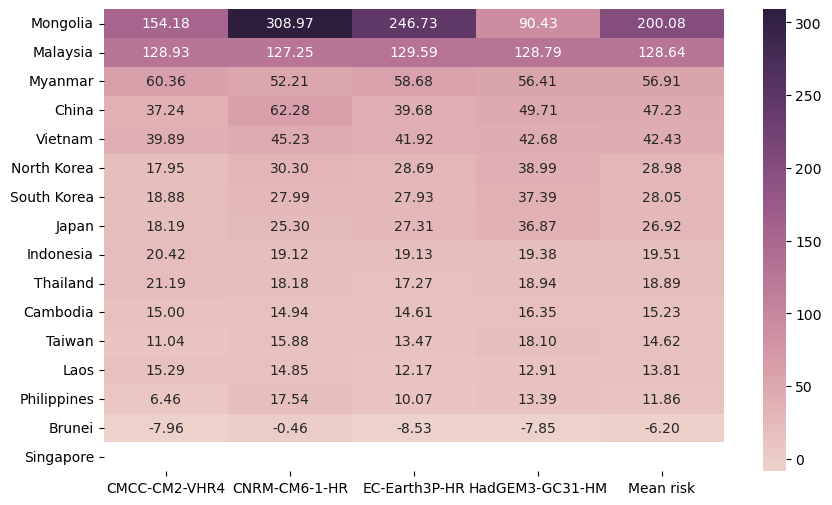

In [141]:
tc_change = tc_risk[['CMCC-CM2-VHR4 change ratio (%)','CNRM-CM6-1-HR change ratio (%)',
                   'EC-Earth3P-HR change ratio (%)','HadGEM3-GC31-HM change ratio (%)',
                   'Mean risk change ratio (%)']]
print(type(tc_change))
tc_change = tc_change.rename(columns={
    'CMCC-CM2-VHR4 change ratio (%)': 'CMCC-CM2-VHR4',
    'CNRM-CM6-1-HR change ratio (%)': 'CNRM-CM6-1-HR',
    'EC-Earth3P-HR change ratio (%)': 'EC-Earth3P-HR',
    'HadGEM3-GC31-HM change ratio (%)': 'HadGEM3-GC31-HM',
    'Mean risk change ratio (%)': 'Mean risk'})

tc_change.insert(0,'Country',['Brunei','China','Indonesia','Japan','Cambodia','South Korea','Laos','Myanmar','Mongolia',
                                    'Malaysia','Philippines','North Korea','Singapore','Thailand','Taiwan','Vietnam'])

tc_change = tc_change.set_index('Country')

tc_change = tc_change.sort_values('Mean risk', ascending=False)

fig, ax = plt.subplots(figsize=(10,6))

heatmap = sns.heatmap(data=tc_change,cmap=sns.cubehelix_palette(as_cmap=True),annot=True,fmt='.2f') #data=tc_change.dropna() #delete countries without risk

#xticklabels = [label.get_text().split(' ', 1)[0] + '\n' + label.get_text().split(' ', 1)[1] for label in ax.get_xticklabels()]
heatmap.set_xticklabels(tc_change.columns,rotation=0,ha='center',fontsize=10)
heatmap.set_ylabel(None)

plt.savefig(os.path.join(figure_path,'Figure 6(a)_TC heatmap.jpg'),dpi=450,bbox_inches='tight')

plt.show()

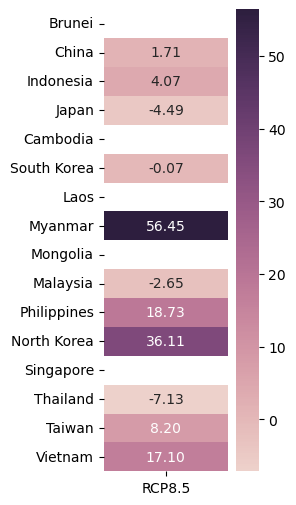

In [129]:
fl_change = fl_risk[['Change ratio (%)']]
fl_change = fl_change.rename(columns={'Change ratio (%)': 'RCP8.5'})

fl_change.insert(0,'Country',['Brunei','China','Indonesia','Japan','Cambodia','South Korea','Laos','Myanmar','Mongolia',
                                    'Malaysia','Philippines','North Korea','Singapore','Thailand','Taiwan','Vietnam'])

fl_change = fl_change.set_index('Country')

#fl_change = fl_change.sort_values('Mean risk', ascending=False)

fig, ax = plt.subplots(figsize=(2,6))

heatmap = sns.heatmap(data=fl_change,cmap=sns.cubehelix_palette(as_cmap=True),annot=True,fmt='.2f')

heatmap.set_xticklabels(fl_change.columns,rotation=0,ha='center',fontsize=10)
heatmap.set_ylabel(None)

plt.savefig(os.path.join(figure_path,'Figure 6(b)_FL heatmap.jpg'),dpi=450,bbox_inches='tight')

plt.show()

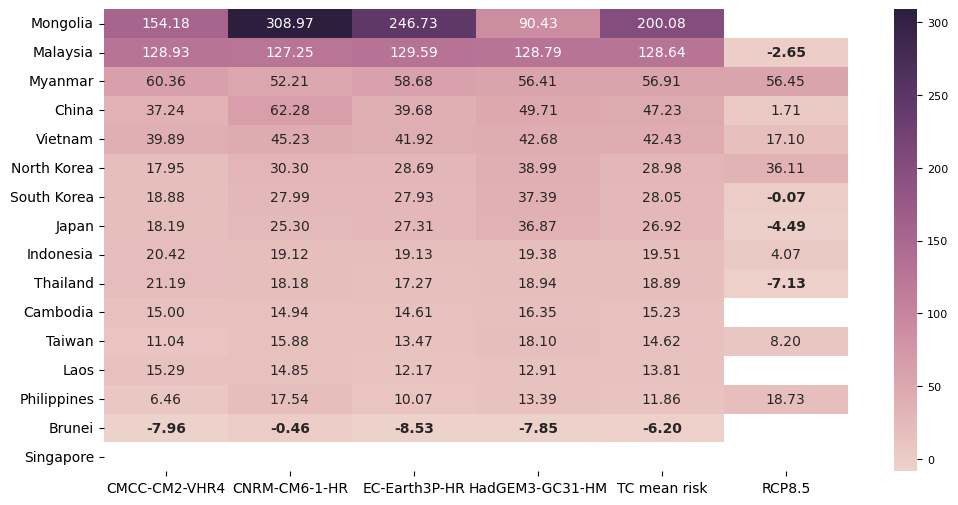

In [134]:
tc_change = tc_risk[['CMCC-CM2-VHR4 change ratio (%)','CNRM-CM6-1-HR change ratio (%)',
                   'EC-Earth3P-HR change ratio (%)','HadGEM3-GC31-HM change ratio (%)',
                   'Mean risk change ratio (%)']]
tc_change = tc_change.rename(columns={
    'CMCC-CM2-VHR4 change ratio (%)': 'CMCC-CM2-VHR4',
    'CNRM-CM6-1-HR change ratio (%)': 'CNRM-CM6-1-HR',
    'EC-Earth3P-HR change ratio (%)': 'EC-Earth3P-HR',
    'HadGEM3-GC31-HM change ratio (%)': 'HadGEM3-GC31-HM',
    'Mean risk change ratio (%)': 'TC mean risk'})

fl_change = fl_risk[['Change ratio (%)']]
fl_change = fl_change.rename(columns={'Change ratio (%)': 'RCP8.5'})

multi_change = pd.concat([tc_change,fl_change],axis=1)
multi_change.insert(0,'Country',['Brunei','China','Indonesia','Japan','Cambodia','South Korea','Laos','Myanmar','Mongolia',
                                    'Malaysia','Philippines','North Korea','Singapore','Thailand','Taiwan','Vietnam'])
multi_change = multi_change.set_index('Country')
multi_change = multi_change.sort_values('TC mean risk', ascending=False)

fig, ax = plt.subplots(figsize=(12,6))

heatmap = sns.heatmap(data=multi_change,cmap=sns.cubehelix_palette(as_cmap=True),annot=True,fmt='.2f') #data=tc_change.dropna() #delete countries without risk
#annot_kws={'fontsize':8}

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)

#xticklabels = [label.get_text().split(' ', 1)[0] + '\n' + label.get_text().split(' ', 1)[1] for label in ax.get_xticklabels()]
heatmap.set_xticklabels(multi_change.columns,rotation=0,ha='center',fontsize=10)
heatmap.set_ylabel(None)

for text in heatmap.texts:
    value = float(text.get_text())
    if value < 0:
        text.set_weight('bold')

plt.savefig(os.path.join(figure_path,'Figure 6_TC&FL heatmap.jpg'),dpi=450,bbox_inches='tight')

plt.show()

In [27]:
multi_risk = pd.concat([tc_risk,fl_risk],axis=1)
multi_risk = multi_risk.drop(multi_risk.columns[[1,2,3,4,5,6,8,9,10]], axis=1)

multi_risk.insert(0,'country_code',['Brunei','China','Indonesia','Japan','Cambodia','South Korea','Laos','Myanmar','Mongolia',
                                    'Malaysia','Philippines','North Korea','Singapore','Thailand','Taiwan','Vietnam'])
multi_risk = multi_risk.set_index('country_code')

multi_risk

,Change ratio (%),Change ratio (%)
country_code,,
Brunei,-6.201214,NaN
China,47.227099,1.705025
Indonesia,19.513563,4.072803
Japan,26.918306,-4.493193
Cambodia,15.225669,NaN
South Korea,28.047367,-0.071896
Laos,13.807645,NaN
Myanmar,56.914592,56.449489
Mongolia,200.078418,NaN


# Create maps based on sum risk

In [136]:
# 根据country_code将数据框与地图数据合并
fl_hist = ne_countries.merge(sum_fl_hist_risk, left_on='SOV_A3', right_on='country_code', how='right')
fl_future = ne_countries.merge(sum_fl_rcp_risk, left_on='SOV_A3', right_on='country_code', how='right')
tc_hist = ne_countries.merge(sum_tc_hist_risk, left_on='SOV_A3', right_on='country_code', how='right')
tc_future = ne_countries.merge(sum_tc_future_risk, left_on='SOV_A3', right_on='country_code', how='right')

In [137]:
fl_future

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry,country_code,climate_model,sum_risk
0,Admin-0 country,0,6,Brunei,BRN,0,2,Sovereign country,1,Brunei,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((115.14617 4.90851, 115.14680 4...",BRN,rcp8p5,0.000000e+00
1,Admin-0 country,0,2,China,CHN,1,2,Country,1,China,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((78.91769 33.38626, 78.91595 33...",CHN,rcp8p5,9.163142e+08
2,Admin-0 country,0,2,Indonesia,IDN,0,2,Sovereign country,1,Indonesia,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",IDN,rcp8p5,3.286435e+07
3,Admin-0 country,0,2,Japan,JPN,0,2,Sovereign country,1,Japan,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((129.78321 31.79963, 129.79086 ...",JPN,rcp8p5,1.518070e+09
4,Admin-0 country,0,3,Cambodia,KHM,0,2,Sovereign country,1,Cambodia,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((107.52039 14.70458, 107.53243 ...",KHM,rcp8p5,0.000000e+00
5,Admin-0 country,0,2,South Korea,KOR,0,2,Sovereign country,1,South Korea,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((128.36492 38.62434, 128.39478 ...",KOR,rcp8p5,3.494443e+08
6,Admin-0 country,0,4,Laos,LAO,0,2,Sovereign country,1,Laos,...,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((102.11866 22.39755, 102.12542 22.383...",LAO,rcp8p5,0.000000e+00
7,Admin-0 country,0,3,Myanmar,MMR,0,2,Sovereign country,1,Myanmar,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((92.57588 21.97757, 92.58384 21...",MMR,rcp8p5,8.514797e+04
8,Admin-0 country,0,3,Mongolia,MNG,0,2,Sovereign country,1,Mongolia,...,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((116.68428 49.82326, 116.47292 49.516...",MNG,rcp8p5,0.000000e+00
9,Admin-0 country,0,3,Malaysia,MYS,0,2,Sovereign country,1,Malaysia,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...",MYS,rcp8p5,9.078306e+06


C:\Users\mye500\AppData\Local\Temp\ipykernel_43400\1605836698.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


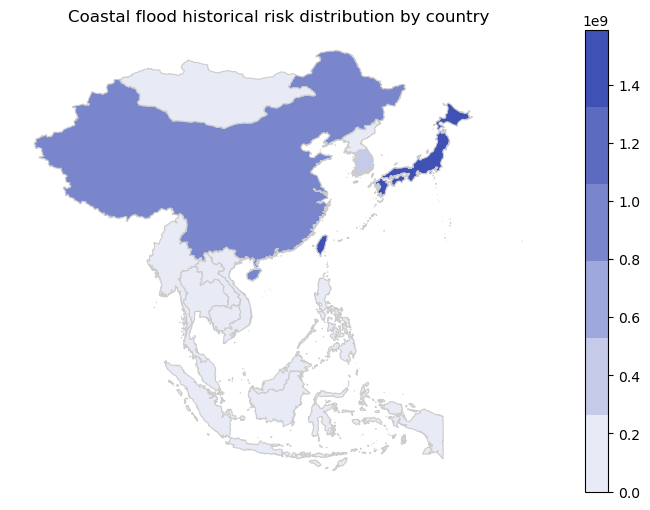

In [138]:
# With normalization
cmap = ListedColormap(['#E8EAF6', '#C5CAE9', '#9FA8DA', '#7986CB', '#5C6BC0', '#3F51B5'])
min_val = fl_hist['sum_risk'].min()
max_val = fl_hist['sum_risk'].max()
norm = Normalize(vmin=min_val, vmax=max_val)

fig, ax = plt.subplots(figsize=(10, 6))
fl_hist.plot(column='sum_risk', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', norm=norm)

ax.set_title('Coastal flood historical risk distribution by country')
ax.set_axis_off()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm)

plt.show()

In [129]:
# calculate relative change of risk
relative_change = ((fl_future.groupby('country_code')['sum_risk'].sum() - fl_hist.groupby('country_code')['sum_risk'].sum())
    / fl_hist.groupby('country_code')['sum_risk'].sum()) * 100

relative_risk = pd.DataFrame({
    'country_code': relative_change.index,
    'relative_change': relative_change.values
})

print(relative_risk)


   country_code  relative_change
0           BRN              NaN
1           CHN         1.705025
2           IDN         4.072803
3           JPN        -4.493193
4           KHM              NaN
5           KOR        -0.071896
6           LAO              NaN
7           MMR        56.449489
8           MNG              NaN
9           MYS        -2.647328
10          PHL        18.730491
11          PRK        36.110998
12          THA        -7.134854
13          TWN         8.204428
14          VNM        17.097631


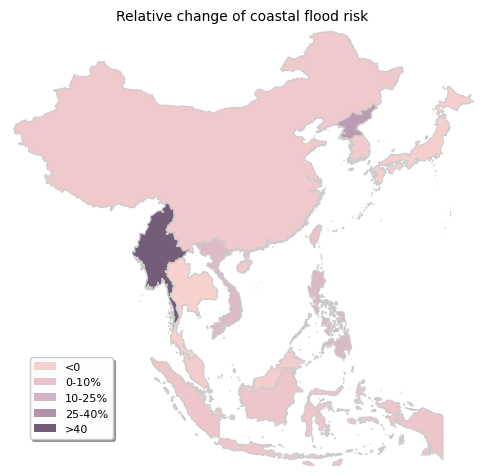

In [217]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

fl_change_map = ne_countries.merge(relative_risk, left_on='SOV_A3', right_on='country_code', how='right')

fig, ax = plt.subplots(figsize=(6,6))

labels = [0,1,2,3,4,5]
label_names = ['<0','0-10%','10-25%','25-40%','>40']
color_scheme = ['#F7D1CD', '#E8C2CA', '#D1B3C4', '#B392AC', '#735D78']
#color_scheme =  ['#F6F6F7','#F2D7EE','#D3BCC0','#A5668B','#69306D','#0E103D']

cmap = LinearSegmentedColormap.from_list(name='continents',colors=color_scheme)
bins = [-10,0,10,20,40]

legend_elements = [Patch(facecolor=color_scheme[0],label=label_names[0]),
                   Patch(facecolor=color_scheme[1],label=label_names[1]),
                   Patch(facecolor=color_scheme[2],label=label_names[2]),
                   Patch(facecolor=color_scheme[3],label=label_names[3]),
                   Patch(facecolor=color_scheme[4],label=label_names[4])]
                   
legend = ax.legend(handles=legend_elements,shadow=True,fancybox=True,facecolor='#fefdfd',prop={'size':8},
                   loc='lower left',bbox_to_anchor=(0.03,0.05, 0.5, 0.5))

fl_change_map.plot(column='relative_change', linewidth=0.8, ax=ax, edgecolor='0.8', cmap=cmap) #, norm=norm

ax.set_title('Relative change of coastal flood risk',fontsize=10)
ax.set_axis_off()

ax.set_xlim(73,146)
ax.set_ylim(-10,54)

plt.show()

# current_xlim = ax.get_xlim()  # get the range of x
# current_ylim = ax.get_ylim()  # get the range of y

# print("Current x-axis range: ", current_xlim)
# print("Current y-axis range: ", current_ylim)